In [3]:
import pandas as pd
import sys
sys.path.append("..")
import utils
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations 

In [4]:
def get_binned_df_list(df, binning_list):
    bin_range = binning_list[-1]
    df_by_chunk = []
    for bin_range in binning_list:
        df_test = df.loc[(df.mean_rating >= bin_range[0]) & (df.mean_rating < bin_range[1])]
        df_by_chunk.append(df_test)
        
    return df_by_chunk


def df_preprocessing(df_list):
    for idx, df in enumerate(df_list):
        df["mean_rating"] = [np.mean(rating) for rating in df.rating]
        df["var_rating"] = [np.var(rating) for rating in df.rating]
        df["std_rating"] = [np.std(rating) for rating in df.rating]
        df["numer_of_ratings"] = [len(r) for r in df.rating]
        df = df.loc[df.numer_of_ratings > 2].reset_index(drop=True)
        df_list[idx] = df
    return df_list

In [9]:
df_20 = pd.read_pickle("../data/ICLR2020/ICLR2020_preprocessed_table.pkl")
df_19 = pd.read_pickle("../data/ICLR2019/ICLR2019_preprocessed_table.pkl")
df_18 = pd.read_pickle("../data/ICLR2018/ICLR2018_preprocessed_table.pkl")
df_17 = pd.read_pickle("../data/ICLR2017/ICLR2017_preprocessed_table.pkl")
dfs = [df_17, df_18, df_19, df_20]
names = ["2017", "2018", "2019", "2020"]

# calculating var&mean ratings, removing papers w/ num of ratings < 3 
dfs = df_preprocessing(dfs)


dfs[0].head()

,decision,title,authors,rating,citations,mean_rating,var_rating,std_rating,numer_of_ratings
0,Accept (Poster),Outrageously Large Neural Networks: The Spars...,"[Noam Shazeer, *Azalia Mirhoseini, *Krzysztof ...","[7, 6, 7]",870.0,6.666667,0.222222,0.471405,3
1,Invite to Workshop Track,Charged Point Normalization: An Efficient Solu...,[Armen Aghajanyan],"[5, 4, 4]",0.0,4.333333,0.222222,0.471405,3
2,Accept (Poster),Bidirectional Attention Flow for Machine Compr...,"[Minjoon Seo, Aniruddha Kembhavi, Ali Farhadi,...","[7, 8, 8]",1690.0,7.666667,0.222222,0.471405,3
3,Accept (Poster),Dynamic Coattention Networks For Question Answ...,"[Caiming Xiong, Victor Zhong, Richard Socher]","[8, 8, 8]",582.0,8.000000,0.000000,0.000000,3
4,Accept (Poster),Normalizing the Normalizers: Comparing and Ext...,"[Mengye Ren, Renjie Liao, Raquel Urtasun, Fabi...","[7, 5, 9]",84.0,7.000000,2.666667,1.632993,3


In [8]:
# dfs[0] = dfs[0].loc[dfs[0].decision != 'Invite to Workshop Track'].reset_index(drop=True)
# dfs[1] = dfs[1].loc[dfs[1].decision != 'Invite to Workshop Track'].reset_index(drop=True)

In [11]:
[(names[i], set(df.decision)) for i, df in enumerate(dfs)]
# poster < spotlight < oral(talk)

[('2017', {'Accept (Oral)', 'Accept (Poster)', 'Invite to Workshop Track'}),
 ('2018', {'Accept (Oral)', 'Accept (Poster)', 'Invite to Workshop Track'}),
 ('2019', {'Accept (Oral)', 'Accept (Poster)'}),
 ('2020', {'Accept (Poster)', 'Accept (Spotlight)', 'Accept (Talk)'})]

### checking the distribution of citation counts

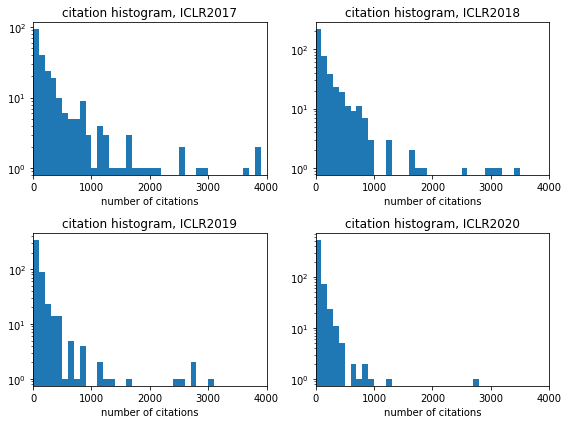

In [4]:
plt.figure(figsize=(8, 6))
for idx, df in enumerate(dfs):
    plt.subplot(2,2, idx+1)
    bins = np.arange(0, 5000, 100)
    plt.hist(df.citations, bins, )
    plt.xlabel("number of citations")
    plt.title(f"citation histogram, ICLR{names[idx]}")
    plt.xlim(0, 4000)
    plt.yscale('log')
plt.tight_layout()
plt.show()


### checking the distribution of mean ratings

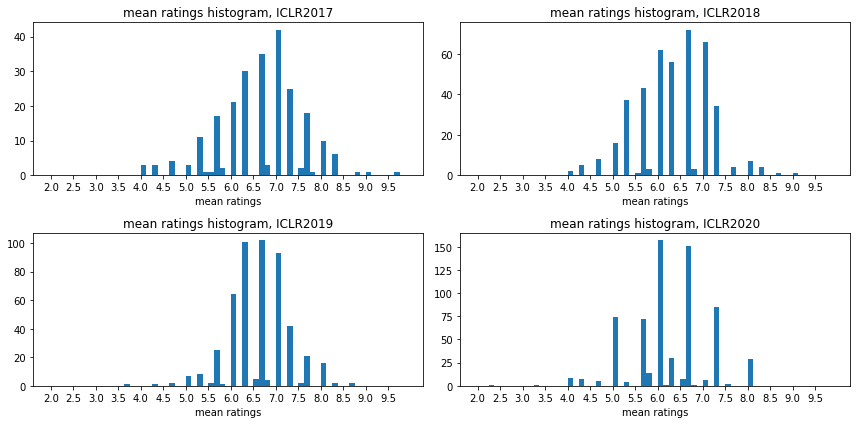

In [5]:

plt.figure(figsize=(12, 6))
for idx, df in enumerate(dfs):
    plt.subplot(2,2, idx+1)
    bins = np.arange(2, 10, 0.125)
    plt.hist(df.mean_rating, bins=bins)
    plt.xlabel("mean ratings")
    plt.title(f"mean ratings histogram, ICLR{names[idx]}")
    plt.xticks(np.arange(2, 10, 0.5))
plt.tight_layout()


plt.show()


### Citations vs mean rating

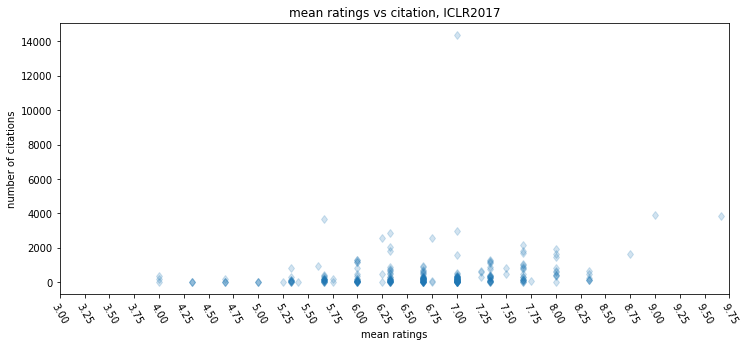

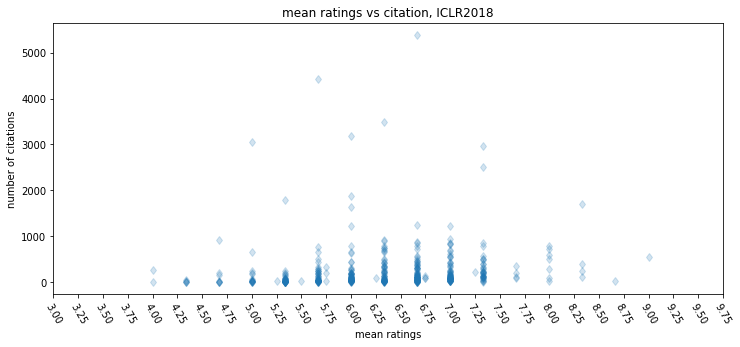

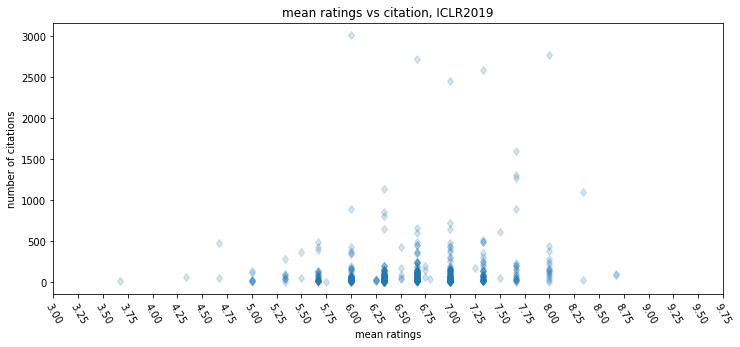

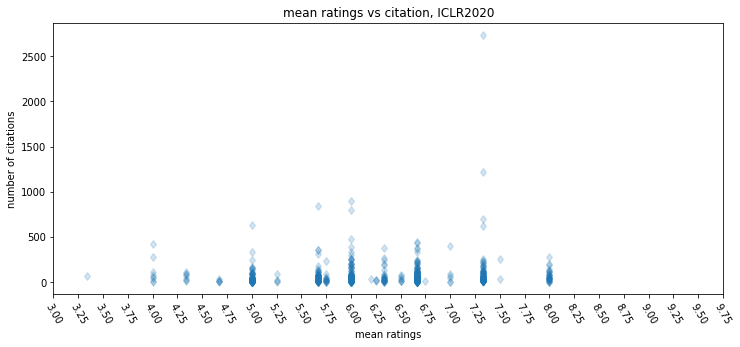

In [6]:
for idx, df in enumerate(dfs):
#     plt.subplot(2,2, idx+1)
    plt.figure(figsize=(12, 5))
    plt.plot(df.mean_rating, df.citations, 'd', alpha=0.2)
    plt.xlabel("mean ratings")
    plt.ylabel("number of citations")
    plt.title(f"mean ratings vs citation, ICLR{names[idx]}")
    plt.xlim(3.2, 9.2)
    plt.xticks(np.arange(3, 10, 0.25), rotation=-60)



### normed median citations vs rating

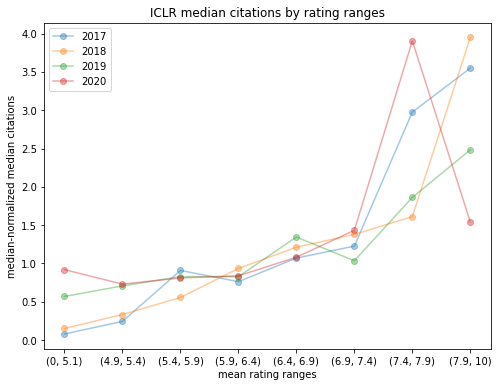

In [7]:
binning_list = [(0, 5.1), (4.9, 5.4), (5.4, 5.9), (5.9, 6.4), (6.4, 6.9), (6.9, 7.4), (7.4, 7.9), (7.9, 10)]
plt.figure(figsize=(8, 6))
for idx, df in enumerate(dfs):
    
    df_by_chunk = get_binned_df_list(df, binning_list)
    median_citations = [np.median(x.citations) for x in df_by_chunk]
    plt.plot(np.array(median_citations) / np.median(df.citations), "o-", label=names[idx], alpha=0.4)
    plt.xticks(range(8), binning_list)
    
plt.title("ICLR median citations by rating ranges")
plt.legend()
plt.ylabel("median-normalized median citations")
plt.xlabel("mean rating ranges")
plt.savefig("../figs/median-normalized_median_citations.png", facecolor="w")
plt.show()

### normed median citations vs STD of rating

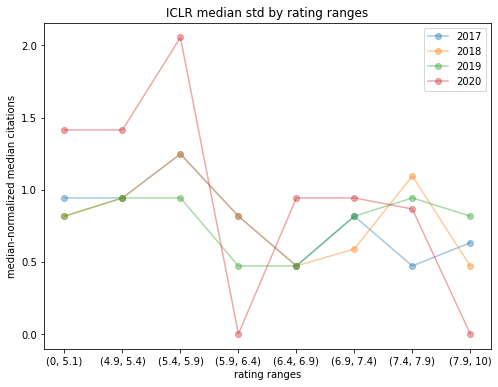

In [8]:
binning_list = [(0, 5.1), (4.9, 5.4), (5.4, 5.9), (5.9, 6.4), (6.4, 6.9), (6.9, 7.4), (7.4, 7.9), (7.9, 10)]
plt.figure(figsize=(8, 6))

for idx, df in enumerate(dfs):
    
    df_by_chunk = get_binned_df_list(df, binning_list)
    median_std = [np.median(np.sqrt(x.var_rating)) for x in df_by_chunk]
    plt.plot(np.array(median_std), "o-", label=names[idx], alpha=0.4)
    plt.xticks(range(8), binning_list)
    
plt.title("ICLR median std by rating ranges")
plt.legend()
plt.ylabel("median-normalized median citations")
plt.xlabel("rating ranges")
plt.show()

### Sandard Error distribution

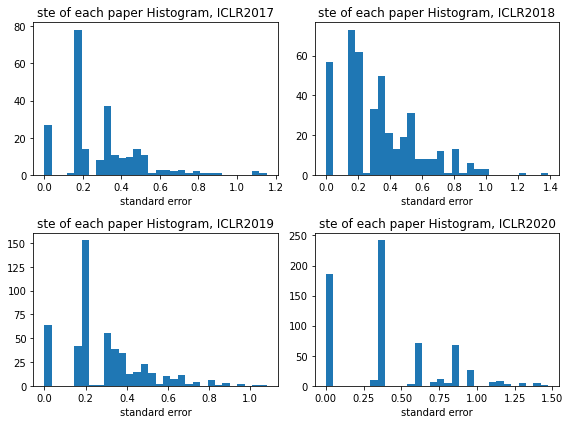

In [9]:
plt.figure(figsize=(8, 6))
for idx, df in enumerate(dfs):
    plt.subplot(2,2, idx+1)
#     bins = np.linspace(3, 9.5, 30)
    standard_error = np.sqrt(df.var_rating) / np.sqrt(df.mean_rating)
    plt.hist(standard_error, bins=30)
    plt.xlabel("standard error")
    plt.title(f"ste of each paper Histogram, ICLR{names[idx]}")
#     plt.xlim(0, 4000)
plt.tight_layout()
plt.show()


### distribution of standard deviation

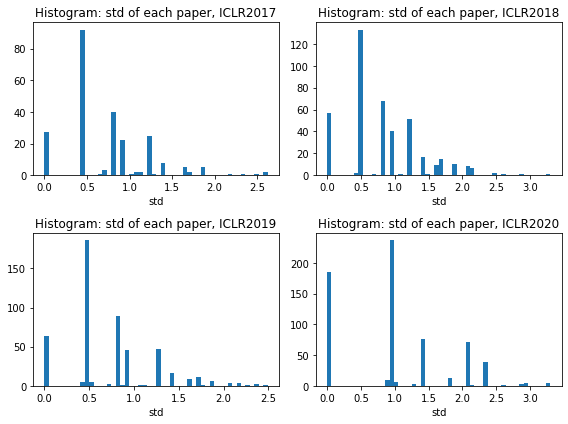

In [10]:
plt.figure(figsize=(8, 6))
for idx, df in enumerate(dfs):
    plt.subplot(2,2, idx+1)
#     bins = np.linspace(3, 9.5, 30)
    std = np.sqrt(df.var_rating)
    plt.hist(std, bins=50)
    plt.xlabel("std")
    plt.title(f"Histogram: std of each paper, ICLR{names[idx]}")
#     plt.xlim(0, 4000)
plt.tight_layout()
plt.show()


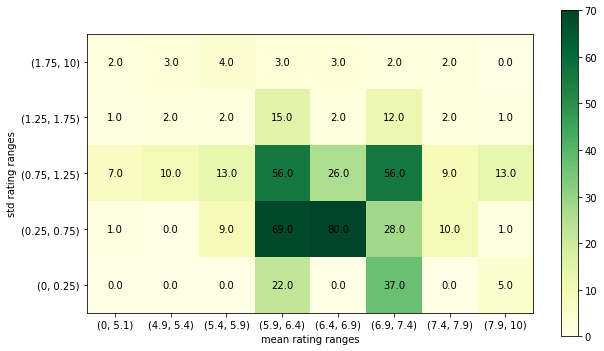

In [11]:
std_rating_bins = [(0,0.25), (0.25,0.75),  (0.75,1.25),  (1.25,1.75),(1.75, 10)]
mean_rating_bins = [(0, 5.1), (4.9, 5.4), (5.4, 5.9), (5.9, 6.4), (6.4, 6.9), (6.9, 7.4), (7.4, 7.9), (7.9, 10)]

df = dfs[2]
n_fraction = np.zeros((len(std_rating_bins), len(mean_rating_bins)))

for i, std_bin in enumerate(std_rating_bins):
    for j, mean_bin in enumerate(mean_rating_bins): 
        df_filtered = df.loc[(df.std_rating >= std_bin[0]) & \
                             (df.std_rating < std_bin[1]) & \
                             (df.mean_rating >= mean_bin[0]) & \
                             (df.mean_rating < mean_bin[1])]
                      
        n_fraction[i, j] = len(df_filtered)
        
        
size_x = len(mean_rating_bins)
size_y = len(std_rating_bins)
data = n_fraction

# Limits for the extent
x_start = 0
x_end = 16
y_start = 0
y_end = 10

extent = [x_start, x_end, y_start, y_end]


levels = np.linspace(0,60,21)


# The normal figure
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
im = ax.imshow(data, extent=extent, origin='lower',
               interpolation='None', cmap='YlGn',
               vmin=0, vmax=70)


# Add the text
jump_x = (x_end - x_start) / (2.0 * size_x)
jump_y = (y_end - y_start) / (2.0 * size_y)
x_positions = np.linspace(start=x_start, stop=x_end, num=size_x, endpoint=False)
y_positions = np.linspace(start=y_start, stop=y_end, num=size_y, endpoint=False)

for y_index, y in enumerate(y_positions):
    for x_index, x in enumerate(x_positions):
        label = data[y_index, x_index]
        text_x = x + jump_x
        text_y = y + jump_y
        ax.text(text_x, text_y, label, color='black', ha='center', va='center')

fig.colorbar(im)
plt.xticks(range(1, 16, 2), mean_rating_bins)
plt.xlabel("mean rating ranges")
plt.yticks(range(1, 10, 2), std_rating_bins)
plt.ylabel("std rating ranges")

plt.show()

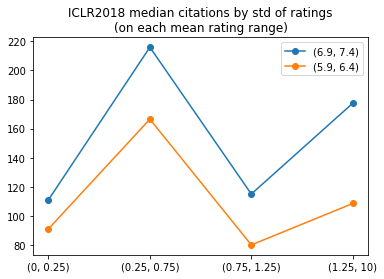

In [12]:
std_rating_bins = [(0,0.25), (0.25,0.75),  (0.75,1.25),  (1.25, 10)]
idx = 1
df = dfs[idx]
df_name = names[idx]
mean_bins = [(6.9, 7.4), (5.9, 6.4)]
for mean_bin in mean_bins:
    citations_list = []
    for i, std_bin in enumerate(std_rating_bins):
        df_filtered = df.loc[(df.std_rating >= std_bin[0]) & \
                             (df.std_rating < std_bin[1]) & \
                             (df.mean_rating >= mean_bin[0]) & \
                             (df.mean_rating < mean_bin[1])]
        citations_list.append(df_filtered.citations.to_numpy())

    plt.plot([np.median(x) for x in citations_list], "o-", label=mean_bin)
plt.xticks(range(4), std_rating_bins)
plt.title(f"ICLR{df_name} median citations by std of ratings\n(on each mean rating range)")
plt.legend()
plt.show()
        
        
        
        

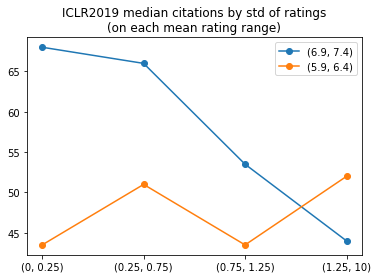

In [13]:
std_rating_bins = [(0,0.25), (0.25,0.75),  (0.75,1.25),  (1.25, 10)]
idx = 2
df = dfs[idx]
df_name = names[idx]
mean_bins = [(6.9, 7.4), (5.9, 6.4)]
for mean_bin in mean_bins:
    citations_list = []
    for i, std_bin in enumerate(std_rating_bins):
        df_filtered = df.loc[(df.std_rating >= std_bin[0]) & \
                             (df.std_rating < std_bin[1]) & \
                             (df.mean_rating >= mean_bin[0]) & \
                             (df.mean_rating < mean_bin[1])]
        citations_list.append(df_filtered.citations.to_numpy())

    plt.plot([np.median(x) for x in citations_list], "o-", label=mean_bin)
plt.xticks(range(4), std_rating_bins)
plt.title(f"ICLR{df_name} median citations by std of ratings\n(on each mean rating range)")
plt.legend()
plt.show()
        
        
        
        

In [14]:
np.std((9, 9, 8)), np.std((7, 8, 9)), np.std((7, 9, 9))

(0.4714045207910317, 0.816496580927726, 0.9428090415820634)